## Predict mammogram results
### Classification with Sequential Neural Net in Python
#### Sean O'Malley

In [19]:
# Import Packages
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Activation, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras import optimizers
from keras.callbacks import EarlyStopping

import pandas
import requests
import io

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import time


In [20]:
# Import Data

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'
data_header =  ['birads','age','shape','margin','density','severity']

data_response = requests.get(data_url).content

df = pd.read_table(io.StringIO(data_response.decode('utf-8')), sep = ',', header = None, na_values = '?')

df.columns = data_header


In [21]:
df.head()

,birads,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [22]:
print(df.isnull().sum()) 
print('-------')
print(df.count())

birads       2
age          5
shape       31
margin      48
density     76
severity     0
dtype: int64
-------
birads      959
age         956
shape       930
margin      913
density     885
severity    961
dtype: int64


Given the not overwealming number of NaNs in the data, I have chosen to move forward with dropping na values

In [23]:
df = df.dropna()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 960
Data columns (total 6 columns):
birads      830 non-null float64
age         830 non-null float64
shape       830 non-null float64
margin      830 non-null float64
density     830 non-null float64
severity    830 non-null int64
dtypes: float64(5), int64(1)
memory usage: 45.4 KB


In [25]:
df.head()

,birads,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
10,5.0,76.0,1.0,4.0,3.0,1


In [26]:
# Optimized data format for NN

Target = np.array(df['severity'])
# drop birads also because its non-predictive
Predictor = np.array(df.drop(['severity','birads'],axis=1))
n_cols = Predictor.shape[1]

In [27]:
print(Predictor.shape, Target.shape)

(830, 4) (830,)


We will be predicting the severty column, where 0 is a benign mass and 1 is a malignant tumor

In [28]:
print(Target)
print('-------')
print(Predictor)

[1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0
 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0
 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1
 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0
 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1
 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0
 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1
 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0
 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0
 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1
 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0
 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 0 1 1 0 1 1 1 0 1 1 

Split into test and training groups

In [29]:
Predictor_train, Predictor_test, Target_train, Target_test = train_test_split(Predictor, Target, test_size=0.2, random_state=42)

Check the shape of the data

In [30]:
print(Predictor_train.shape, Predictor_test.shape, Target_train.shape, Target_test.shape)

(664, 4) (166, 4) (664,) (166,)


#### Initial Model Build

Sequential neural net structure with relu activation function and 100 nodes in each hidden layer

In [31]:
model = Sequential()
model.add(Dense(16,input_shape=(n_cols,),activation='relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

View model summary

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


Compile model, view accuracy metric

In [33]:
model.compile(optimizer= 'adam', loss ='binary_crossentropy', metrics=['accuracy'])

Fit initial model

In [34]:
model.fit(Predictor_train, Target_train, batch_size=30, epochs=20)

Epoch 1/20
664/664 [==============================] - 0s 341us/step - loss: 1.1929 - acc: 0.4970
Epoch 2/20
664/664 [==============================] - 0s 191us/step - loss: 0.6847 - acc: 0.5407
Epoch 3/20
664/664 [==============================] - 0s 152us/step - loss: 0.6578 - acc: 0.6566
Epoch 4/20
664/664 [==============================] - 0s 157us/step - loss: 0.6432 - acc: 0.6175
Epoch 5/20
664/664 [==============================] - 0s 172us/step - loss: 0.6303 - acc: 0.7726
Epoch 6/20
664/664 [==============================] - 0s 205us/step - loss: 0.6271 - acc: 0.6762
Epoch 7/20
664/664 [==============================] - 0s 147us/step - loss: 0.6227 - acc: 0.7078
Epoch 8/20
664/664 [==============================] - 0s 193us/step - loss: 0.6044 - acc: 0.7681
Epoch 9/20
664/664 [==============================] - 0s 167us/step - loss: 0.6000 - acc: 0.7560
Epoch 10/20
664/664 [==============================] - 0s 166us/step - loss: 0.5903 - acc: 0.7666
Epoch 11/20
664/664 [========

### Initial Results

We have a model that is doing a pretty decent job in our first go around. Using a fairly simple 3 layered model, we can make improvements on loss and accuracy, but we certainly need to push further because the cost of a misdiagnosis is far too grave to not strive for perfect predictions.

#### Bigger model, early stopping implemented, tune optimizer, track results

In [35]:
def get_new_model():
    model = Sequential()
    model.add(Dense(25,input_shape=(n_cols,),activation='relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

Lets make the optimizer better, but also create a vector of learning rates to see which one could work better

In [36]:
# Create list of learning rates: lr_to_test
lr_to_test = [0.000001,0.01,1]

# Loop over learning rates
for lr in lr_to_test:
    print('\n\nTest learning rate: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = get_new_model()
    
    # Create SGD optimizer with specified learning rate: my_optimizer
    my_optimizer = optimizers.Adam(lr = lr)
    
    # Compile the model
    model.compile(optimizer = my_optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
    
    # Fit the model
    model.fit(Predictor_train, Target_train, batch_size=30, epochs=20)




Test learning rate: 0.000001

Epoch 1/20
664/664 [==============================] - 0s 384us/step - loss: 3.2882 - acc: 0.4910
Epoch 2/20
664/664 [==============================] - 0s 156us/step - loss: 3.2721 - acc: 0.4910
Epoch 3/20
664/664 [==============================] - 0s 140us/step - loss: 3.2565 - acc: 0.4910
Epoch 4/20
664/664 [==============================] - 0s 172us/step - loss: 3.2408 - acc: 0.4910
Epoch 5/20
664/664 [==============================] - 0s 179us/step - loss: 3.2253 - acc: 0.4910
Epoch 6/20
664/664 [==============================] - 0s 152us/step - loss: 3.2098 - acc: 0.4910
Epoch 7/20
664/664 [==============================] - 0s 142us/step - loss: 3.1941 - acc: 0.4910
Epoch 8/20
664/664 [==============================] - 0s 148us/step - loss: 3.1781 - acc: 0.4910
Epoch 9/20
664/664 [==============================] - 0s 156us/step - loss: 3.1627 - acc: 0.4910
Epoch 10/20
664/664 [==============================] - 0s 143us/step - loss: 3.1471 - acc: 0.49

Hey, that was a fun little exercise to see how the different learning rates work. It looks like the best learning rate so far is 0.01 given our nodes and layers involved. Knowing this, we will move forward with this learning rate and then implement the early stop function.

#### Early Stopping

If the neural net stops learning for 3 epochs, we stop the forward/back propogation process.

In [37]:
# initial build
model = Sequential()
model.add(Dense(25,input_shape=(n_cols,),activation='relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# instantiate your adam optimizer and change the learning rate to 0.01 and compile
adam = optimizers.Adam(lr=0.01)
model.compile(optimizer = adam, loss ='binary_crossentropy', metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience = 3)

# Fit the model
model.fit(Predictor_train, Target_train, batch_size=30, epochs = 30, validation_split = 0.2, callbacks = [early_stopping_monitor])


Train on 531 samples, validate on 133 samples
Epoch 1/30
531/531 [==============================] - 0s 720us/step - loss: 1.4986 - acc: 0.4727 - val_loss: 0.8356 - val_acc: 0.5338
Epoch 2/30
531/531 [==============================] - 0s 179us/step - loss: 0.7184 - acc: 0.5424 - val_loss: 0.7363 - val_acc: 0.4812
Epoch 3/30
531/531 [==============================] - 0s 181us/step - loss: 0.6710 - acc: 0.5687 - val_loss: 0.6647 - val_acc: 0.5338
Epoch 4/30
531/531 [==============================] - 0s 142us/step - loss: 0.6557 - acc: 0.6064 - val_loss: 0.6296 - val_acc: 0.6541
Epoch 5/30
531/531 [==============================] - 0s 175us/step - loss: 0.6047 - acc: 0.6798 - val_loss: 0.7121 - val_acc: 0.5263
Epoch 6/30
531/531 [==============================] - 0s 193us/step - loss: 0.5901 - acc: 0.6911 - val_loss: 0.5733 - val_acc: 0.6617
Epoch 7/30
531/531 [==============================] - 0s 180us/step - loss: 0.5239 - acc: 0.7646 - val_loss: 0.5417 - val_acc: 0.7218
Epoch 8/30
531/5

Interesting, the early stopping ends at epoch 16 because the loss was increasing, however the accuracy was improving over the last 3. 

To understand what is going on more here, lets get a visual on the relationship between the epoch and learning rate. 

In [38]:
# Create UDF's
def mymodel(n=[25,50,50]):
    model = Sequential()
    model.add(Dense(n[0],input_shape=(4,)))
    model.add(Activation('relu'))
    model.add(Dense(n[1]))
    model.add(Activation('relu'))
    model.add(Dense(n[2]))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

def mytrain(model, lr=0.01, batch=32, epochs=20):
    adam = optimizers.Adam(lr=lr) 
    model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])
    result = model.fit(Predictor_train, Target_train, batch_size=batch, epochs=epochs,verbose=0)
    return result.history

In [39]:
# To visualize this, lets put it all in a nested for loop
for ep in [10,25,50,100,200]:
    for lr in [0.1,0.01,0.001,0.0001,0.00001]:
        model = mymodel()
        res = mytrain(model,lr,32,ep)
        print(ep,lr,np.argmax(res['acc']),'{:.3f}'.format(max(res['acc'])))

10 0.1 0 0.509
10 0.01 6 0.782
10 0.001 8 0.786
10 0.0001 6 0.779
10 1e-05 5 0.491
25 0.1 1 0.491
25 0.01 20 0.792
25 0.001 22 0.788
25 0.0001 15 0.780
25 1e-05 24 0.556
50 0.1 6 0.509
50 0.01 40 0.794
50 0.001 31 0.795
50 0.0001 39 0.774
50 1e-05 28 0.660
100 0.1 0 0.503
100 0.01 78 0.806
100 0.001 88 0.797
100 0.0001 91 0.785
100 1e-05 99 0.705
200 0.1 3 0.491
200 0.01 195 0.803
200 0.001 181 0.800
200 0.0001 198 0.797
200 1e-05 194 0.679


We are really seeing ceiling on the accuracy of this dataset given many of the parameters we have available for us to tune. The best thus far is 200 epochs with a learning rate of 0.01, this is a pretty aggressive neural net design, implying that the highger learning rate and epoch number helps reduce error the most.

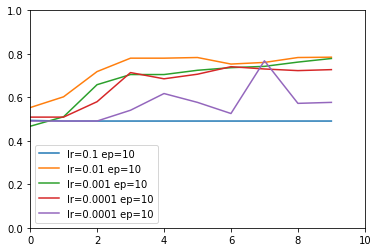

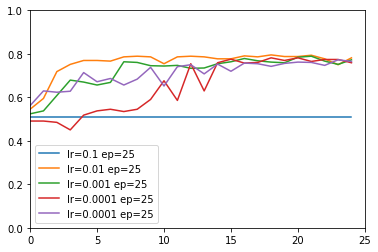

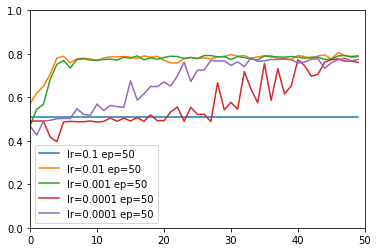

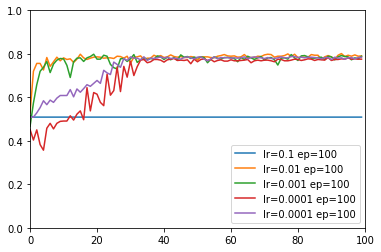

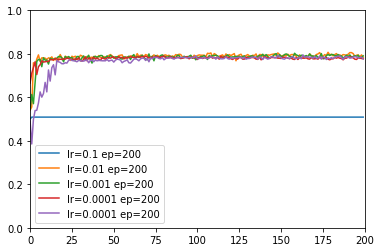

In [40]:
# Lets plot what we just did above
%matplotlib inline

for ep in [10,25,50,100,200]:
    for lr in [0.1,0.01,0.001,0.0001,0.0001]:
        model = mymodel()
        res = mytrain(model,lr,32,ep)
        plt.ylim(0,1)
        plt.xlim(0,ep)
        plt.plot(res['acc'],label='lr='+str(lr)+' ep='+str(ep))
        plt.legend()
    plt.show()  

Wow, this is interesting. Its showing that I can't really get any better than that 80% accuracy, the learning rate and epochs are simply the pace in which I get there. For learning rates of 0.1 and 0.01 we arrive at around 80% accuracy in 8 to 10 epochs, while learning rates of 0.0001 and 0.001 take about 30 epochs to arrrive at that same 80% accuracy mark.

The ceiling of 80% matters more than anything, so lets manipulate the number of neurons in our 3 predefined layers that need to be used in this analysis, to see if we can increase accuracy.

In [41]:
configs = [[4,4,4],[8,8,8],[16,16,16],[32,16,16],[20,40,60],[100,100,100],[150,150,150]]
for conf in configs:
    model = mymodel(conf)
    t0=time.time()
    res = mytrain(model,lr=0.01,batch=32,epochs=50)
    t1=time.time() #I'm timing to check training time vs model size
    print(conf, '{:.3f}'.format(t1-t0), model.count_params(),np.argmax(res['acc']),'{:.3f}'.format(max(res['acc'])))

[4, 4, 4] 7.319 65 0 0.521
[8, 8, 8] 7.368 193 37 0.800
[16, 16, 16] 7.476 641 38 0.797
[32, 16, 16] 7.935 977 2 0.512
[20, 40, 60] 7.572 3461 28 0.795
[100, 100, 100] 7.593 20801 48 0.804
[150, 150, 150] 7.797 46201 49 0.795


Dang, we are still seeing the accuracy limit of around 80%, lets see if experimenting with the number of layers could be helpful. We will move forward with 100 neurons in each layer

In [45]:
def model_nlayer(n): #fixed num_neuron to 32
    model = Sequential()
    model.add(Dense(100,input_shape=(n_cols,)))
    for i in range(n-1):
        model.add(Dense(100,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    return model

for nlayer in [1,3,5,7,9,11]:
    model = model_nlayer(nlayer)
    t0=time.time()
    res = mytrain(model,lr=0.01,batch=32,epochs=50)
    t1=time.time() #I'm timing to check training time vs model size
    print(nlayer, '{:.3f}'.format(t1-t0), model.count_params(),np.argmax(res['acc']),'{:.3f}'.format(max(res['acc'])))

1 7.945 601 47 0.797
3 8.574 20801 10 0.509
5 9.842 41001 33 0.798
7 10.698 61201 22 0.800
9 11.608 81401 19 0.779
11 12.357 101601 1 0.556


Still not quite seeing the improvement in accuracy we would like

In [47]:
import tensorflow as tf # an alternative accuracy calculation (what Keras actually uses)

def acc(yp, yt):
    assert yp.shape==yt.shape, 'shape of yp and yt do not match'
    return np.mean(yp == yt)

def acc_tf(yp, yt):
    assert yt.shape == yp.shape, "yp and yt shape do not match"
    sess = tf.InteractiveSession()
    acc = K.mean(K.equal(tf.convert_to_tensor(yt), tf.cast(K.round(tf.convert_to_tensor(yp)),dtype=tf.int64))).eval()
    return acc

In [76]:

Target_pred = model.predict(Predictor_test)
Target_pred = Target_pred[:,0].round()
Target_class = Target_test
acc(Target_class, Target_pred)


0.53614457831325302

Our accuracy on the test group is worse than the training group

Using the loop provided, we will now compare accuracy on the test dataset given various epoch sizes. Outputting accuracy, residuals and metrics.

In [81]:
for ep in [25,50,150]:
    model = mymodel()
    adam = optimizers.Adam() 
    model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])
    res = model.fit(Predictor_train, Target_train, batch_size=32, epochs=25,verbose=0) #model.fit returns an object
    best_train_acc = max(res.history['acc']) #, which you can retrieve metrics if you chose a metric
    metric = model.evaluate(Predictor_test, Target_test, batch_size=32, verbose=0) 
    print(ep, best_train_acc, metric[1])
    

25 0.789156627224 0.765060240246
50 0.792168674699 0.75903614386
150 0.792168675417 0.765060240246


This shows that we actually aren't doing too bad. We can predict with 76.5% accuracy on the test dataset

Lets look at validation loss and validation metrics to see how well things are working for us. Given everything we have learned so far, lets build a model that has all the features that perormed the best for us

In [88]:
def modelfinal():
    model = Sequential()
    model.add(Dense(25,input_shape=(n_cols,),activation='relu')) #1
    model.add(Dense(50, activation = 'relu')) #2
    model.add(Dense(100, activation = 'relu')) #3
    model.add(Dense(100, activation = 'relu')) #4
    model.add(Dense(100, activation = 'relu')) #5
    model.add(Dense(50, activation = 'relu')) # 6
    model.add(Dense(1, activation = 'sigmoid')) # 7
    adam = optimizers.Adam(lr=0.01)
    model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])    
    return model

In [89]:
model = modelfinal()
early_stopping_monitor = EarlyStopping(patience = 5)
res = model.fit(Predictor_train, Target_train, validation_split=0.3, epochs=150, batch_size=32, callbacks = [early_stopping_monitor])

Train on 464 samples, validate on 200 samples
Epoch 1/150
464/464 [==============================] - 5s 10ms/step - loss: 0.7879 - acc: 0.5000 - val_loss: 0.6779 - val_acc: 0.5450
Epoch 2/150
464/464 [==============================] - 0s 370us/step - loss: 0.6708 - acc: 0.5970 - val_loss: 0.6256 - val_acc: 0.7150
Epoch 3/150
464/464 [==============================] - 0s 346us/step - loss: 0.5694 - acc: 0.7586 - val_loss: 0.6086 - val_acc: 0.7150
Epoch 4/150
464/464 [==============================] - 0s 384us/step - loss: 0.5133 - acc: 0.7823 - val_loss: 0.5883 - val_acc: 0.7400
Epoch 5/150
464/464 [==============================] - 0s 427us/step - loss: 0.5180 - acc: 0.7802 - val_loss: 0.5494 - val_acc: 0.7300
Epoch 6/150
464/464 [==============================] - 0s 341us/step - loss: 0.5089 - acc: 0.7737 - val_loss: 0.5931 - val_acc: 0.7550
Epoch 7/150
464/464 [==============================] - 0s 361us/step - loss: 0.4967 - acc: 0.7737 - val_loss: 0.5188 - val_acc: 0.7600
Epoch 8/15

After 12 epochs we see that we our top accuracy is 76.5% given the final model parameters. Now, lets plot the residuals.

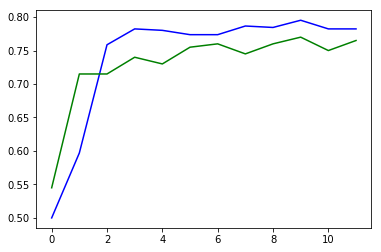

In [90]:
plt.plot(res.history['acc'],'b')
plt.plot(res.history['val_acc'],'g')

The residuals highlight much of what we have seen from this problem. We figure just short of 80% fairly quickly, but then really top out after that, and early stopping kicks in at 12 epochs.

In [ ]:
Now lets do a final test of accuracy on the test datasets.

In [99]:
model = modelfinal()
early_stopping_monitor = EarlyStopping(patience = 5)
res = model.fit(Predictor_test, Target_test, validation_split=0.3, epochs=150, batch_size=32, callbacks = [early_stopping_monitor])

Train on 116 samples, validate on 50 samples
Epoch 1/150
116/116 [==============================] - 5s 41ms/step - loss: 2.0519 - acc: 0.4052 - val_loss: 1.5288 - val_acc: 0.4800
Epoch 2/150
116/116 [==============================] - 0s 285us/step - loss: 0.9109 - acc: 0.5603 - val_loss: 0.6866 - val_acc: 0.5200
Epoch 3/150
116/116 [==============================] - 0s 369us/step - loss: 0.7754 - acc: 0.4397 - val_loss: 0.6739 - val_acc: 0.5200
Epoch 4/150
116/116 [==============================] - 0s 452us/step - loss: 0.7002 - acc: 0.4741 - val_loss: 0.7209 - val_acc: 0.4800
Epoch 5/150
116/116 [==============================] - 0s 441us/step - loss: 0.6882 - acc: 0.5603 - val_loss: 0.6830 - val_acc: 0.6600
Epoch 6/150
116/116 [==============================] - 0s 443us/step - loss: 0.6927 - acc: 0.5172 - val_loss: 0.6666 - val_acc: 0.5800
Epoch 7/150
116/116 [==============================] - 0s 458us/step - loss: 0.6745 - acc: 0.6466 - val_loss: 0.6920 - val_acc: 0.4800
Epoch 8/150

## Conclusion

Using the test data we can see that with 8 epochs we get an accuracy of 82%, which is pretty good considering the struggle it was to improve our  model past that 80% accuracy threshold.

At the end of the day, we were limited in our predictive power given that we only had 4 columns to use as predictors. So, though I would love for the accuracy to be improved, the fact that we could predict the severity of a mammographic mass only knowing 4 things with 82% accuracy is pretty solid. 